<a href="https://www.kaggle.com/code/kadenchow/mnist-datatset-neural-network-practice?scriptVersionId=272191217" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.
_, m_train = X_train.shape

In [3]:
Y_train

array([9, 7, 2, ..., 0, 2, 2])

In [4]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./20)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(784))
    return W1, b1, W2, b2
    #W1 = np.random.rand(10, 784) - 0.5
    #b1 = np.random.rand(10, 1) - 0.5
    #W2 = np.random.rand(10, 10) - 0.5
    #b2 = np.random.rand(10, 1) - 0.5
    #return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)

def softmax(Z):
    Z -= np.max(Z, axis=0)  # Subtract max value for numerical stability
    A = np.exp(Z) / np.sum(np.exp(Z), axis=0)
    return A
    #A = np.exp(Z) / sum(np.exp(Z))
    #return A

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z):
    return Z > 0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

#def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    #one_hot_Y = one_hot(Y)
    #dZ2 = A2 - one_hot_Y
    #dW2 = 1 / m * dZ2.dot(A1.T)
    #db2 = 1 / m * np.sum(dZ2)
    #dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    #dW1 = 1 / m * dZ1.dot(X.T)
    #db1 = 1 / m * np.sum(dZ1)
    #return dW1, db1, dW2, db2

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1] # <-- FIX 1: Define 'm' (number of examples)
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    # FIX 2: Sum over examples (axis=1) and keep dimensions
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True) 
    
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    # FIX 3: Sum over examples (axis=1) and keep dimensions
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True) 
    
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1 
    W2 = W2 - alpha * dW2 
    b2 = b2 - alpha * db2  
    return W1, b1, W2, b2

def cross_entropy_loss(A2, Y):
    """
    Calculates the categorical cross-entropy loss.
    A2 (predictions) is shape (10, m)
    Y (true labels) is shape (m,) [e.g., [5, 0, 4, ...]]
    """
    m = Y.shape[0] # Number of examples
    
    # Clip A2 to avoid log(0)
    epsilon = 1e-12
    A2 = np.clip(A2, epsilon, 1. - epsilon)
    
    # Select the predicted probabilities for the correct class
    # A2[Y, np.arange(m)] selects:
    #   For example 0 (col 0), the probability at class Y[0]
    #   For example 1 (col 1), the probability at class Y[1]
    #   ...and so on for all 'm' examples
    correct_log_probs = -np.log(A2[Y, np.arange(m)])
    
    # Compute the average loss
    loss = np.sum(correct_log_probs) / m
    return loss

In [5]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def stochastic_gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    loss_history = []
    
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 50 == 0:
            print("Epoch:", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
        if i % 1 == 0: # Calculate and store every epoch
            current_loss = cross_entropy_loss(A2, Y) 
            loss_history.append(current_loss)
            
            if i % 50 == 0:
                print(f"Iteration {i+1}/{iterations} | Loss: {current_loss:.4f}")
        
    return W1, b1, W2, b2, loss_history

In [6]:
W1, b1, W2, b2, training_loss = stochastic_gradient_descent(X_train, Y_train, 0.1, 500)

Epoch: 0
[7 2 4 ... 2 7 2] [9 7 2 ... 0 2 2]
0.09373170731707317
Iteration 1/500 | Loss: 2.3199
Epoch: 50
[9 7 1 ... 0 2 2] [9 7 2 ... 0 2 2]
0.7008048780487804
Iteration 51/500 | Loss: 1.2587
Epoch: 100
[9 7 1 ... 0 2 2] [9 7 2 ... 0 2 2]
0.829390243902439
Iteration 101/500 | Loss: 0.7045
Epoch: 150
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.8625609756097561
Iteration 151/500 | Loss: 0.5359
Epoch: 200
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.8793170731707317
Iteration 201/500 | Loss: 0.4592
Epoch: 250
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.888219512195122
Iteration 251/500 | Loss: 0.4159
Epoch: 300
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.8937560975609756
Iteration 301/500 | Loss: 0.3880
Epoch: 350
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.8977073170731708
Iteration 351/500 | Loss: 0.3683
Epoch: 400
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.901219512195122
Iteration 401/500 | Loss: 0.3535
Epoch: 450
[9 7 2 ... 0 2 2] [9 7 2 ... 0 2 2]
0.9040975609756098
Iteration 451/500 | Loss: 0.3419


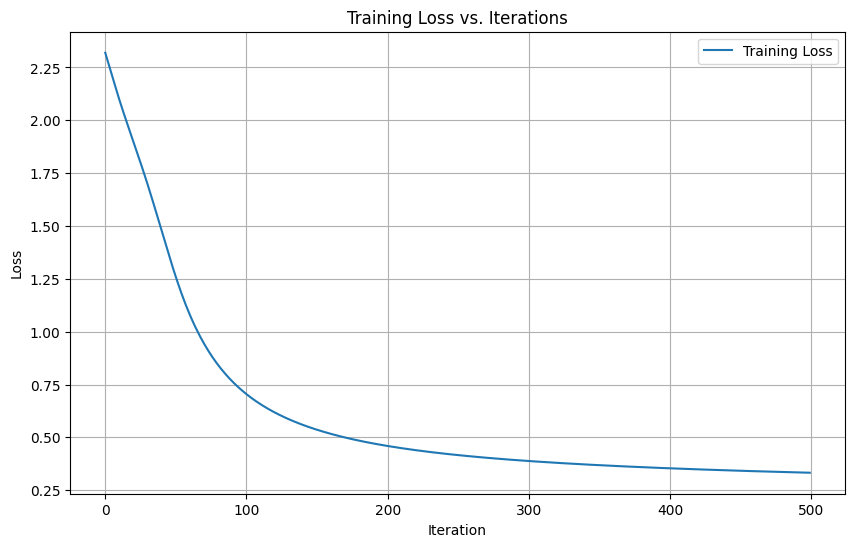

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.title('Training Loss vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [9]
Label:  9


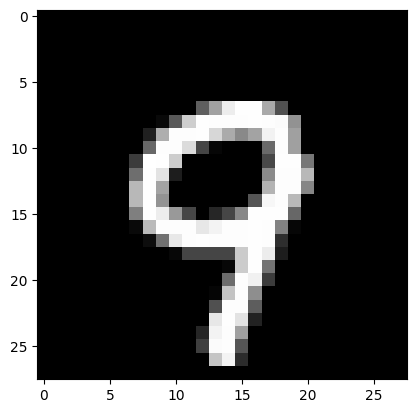

Prediction:  [7]
Label:  7


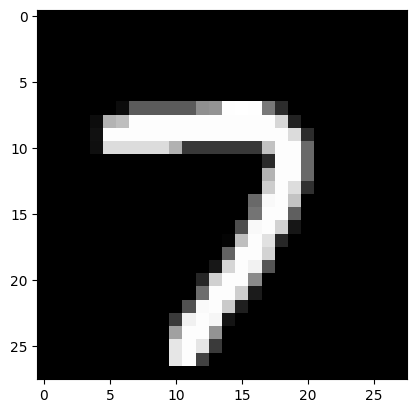

Prediction:  [2]
Label:  2


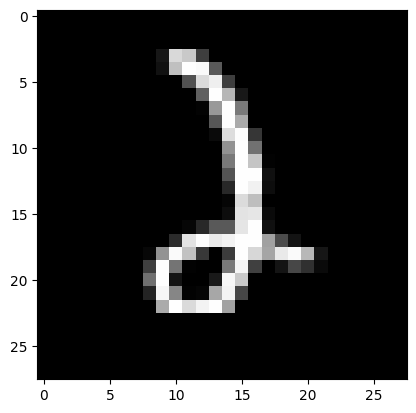

Prediction:  [3]
Label:  3


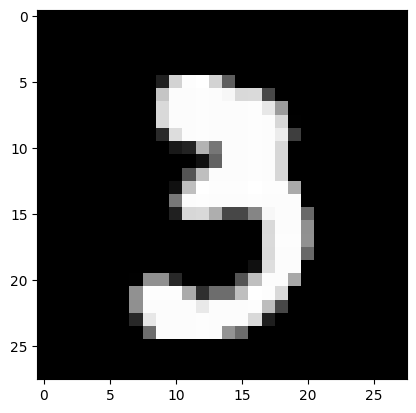

Prediction:  [9]
Label:  9


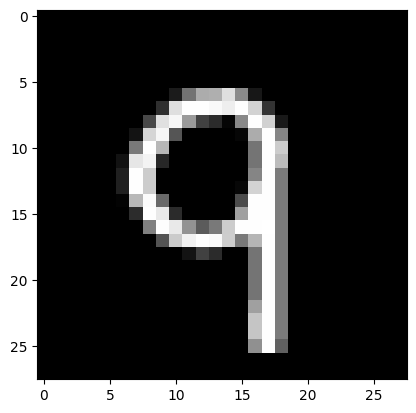

Prediction:  [1]
Label:  1


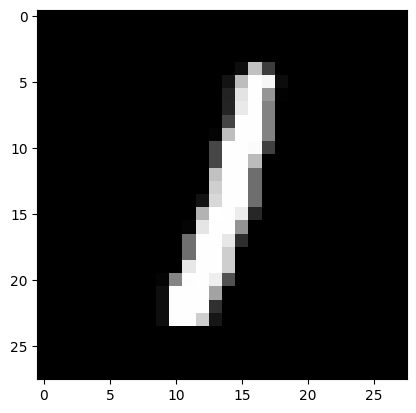

Prediction:  [0]
Label:  2


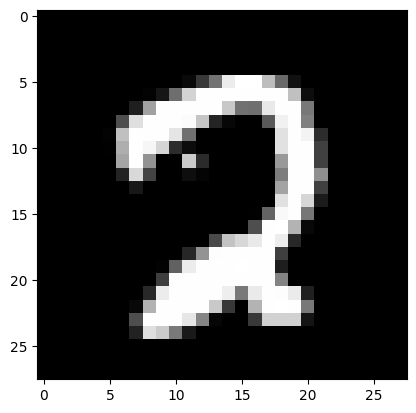

Prediction:  [1]
Label:  1


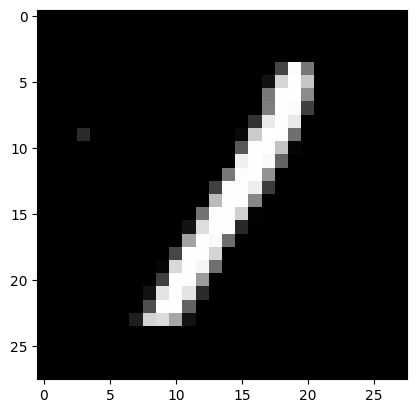

Prediction:  [7]
Label:  7


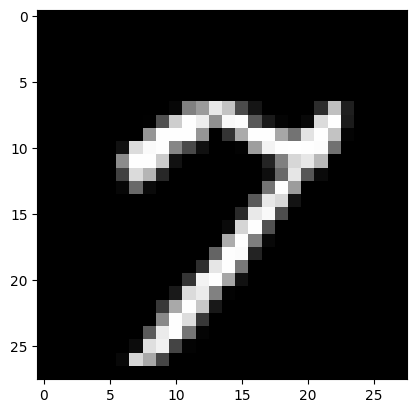

Prediction:  [5]
Label:  5


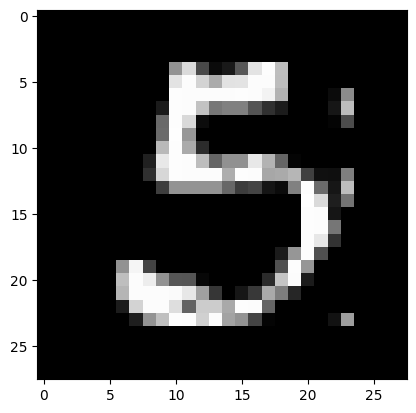

In [9]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(4, W1, b1, W2, b2)
test_prediction(5, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(7, W1, b1, W2, b2)
test_prediction(8, W1, b1, W2, b2)
test_prediction(9, W1, b1, W2, b2)